# Basic RBM gammapy analysis for VERITAS data

Versions: gammapy-tools (1.0.0), gammapy (1.1) and V2DL3 (0.5)

This notebook is version 0.2

Uses [rbm.py](../scripts/rbm.py) and [data_products.py](../scripts/data_products.py) for 2D RBM and 1D spectral/LC analyses, respectively.

Optionally, [makeBackground.py](../background_from_bkg/makeBackground/makeBackground.py) can be used to generate bkg headers here. bkg generation and attachment can also be done in [the prepare_dataset notebook](prepare_dataset.ipynb). 

**If you already have DL3 files with bkg headers, you can skip step 2.**

In [1]:
import sys
import numpy as np
import yaml
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import os

import astropy.units as u

from gammapy_tools.templates import get_config
from gammapy_tools.make_background import *
import gammapy_tools.make_background as bkg
from gammapy_tools.analysis import make_spectrum_RE, get_flux_lc, rbm_analysis, rbm_plots, write_validation_info

from gammapy.data import DataStore

import warnings
warnings.filterwarnings("ignore")

In [2]:
import gammapy_tools
gammapy_tools.__file__

'/homes/wang/swong/.local/lib/python3.9/site-packages/gammapy_tools/__init__.py'

## 1. Set up bkg and analysis configuration

***Note: bkg $\equiv$ radial acceptance!***

This should be a "full" config file containing background generation information as well as analysis (RBM + 1D spectra and lightcurve) information. 

An example config file is [example_config.yaml](example_config.yaml). Instructions for setting up the config file are listed as comments within the example file. 

Even if you have generated bkg headers elsewhere, the `'io'`, `'exclusion'`, `'analysis_selection'`, and `'run_selection'` parameters are re-used in the scripts needed to run this notebook.

In [6]:
with open('crab_test.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [7]:
config

{'io': {'runlist': '/raid/romulus/swong/ED490/Eventdisplay_AnalysisScripts_VTS/scripts/crab_test.txt',
  'search_datastore': '/raid/romulus/dl3/ed/dl3_fullenclosure_moderate2tel/',
  'in_dir': '/raid/romulus/swong/mydl3/crabtest/',
  'out_dir': '/raid/romulus/swong/mydl3/crabtestbkgs/',
  'results_dir': '/raid/romulus/swong/mydl3/crabtest/results/',
  'from_run': False,
  'from_runlist': True},
 'binning': {'e_min': 0.1,
  'e_max': 100,
  'e_bins': 10,
  'off_min': 0,
  'off_max': 2.5,
  'off_bins': 5},
 'config': {'njobs': 16},
 'exclusion': {'star_cat': './Hipparcos_MAG8_1997.dat',
  'exclude_source_name': None,
  'exclude_regions': None},
 'background_selection': {'nsb_diff': 1.5,
  'el_diff': 1,
  'az_diff': 45,
  'n_tels': 4,
  'time_max': 180,
  'smooth': True,
  'smooth_sigma': 1,
  'same_szn': True,
  'time_request': 50,
  'KL_DIV': True,
  'store_KL': False},
 'run_selection': {'source_name': 'Crab',
  'pos_from_DL3': True,
  'offset_max': 3.5,
  'n_tel': 3,
  'el_min': 30},
 

# 2. Background generation

The following lines generate bkg headers for runs matching the conditions defined in `config['background_selction']`. Run-wise background generation is currently not supported but this can be found in `examples/prepare_dataset`. 

**If you wish to skip bkg generation, make sure your DL3 files with attached bkg headers are located in `config['io']['out_dir']` and skip to step 3**

## Load in our data runs

Our DL3 files are contained in the config file in `config['io']['in_dir']`- let's load those in and look at our runlist

Alternatively, if you have preprocessed anasum files on disk or only want to use selected runs in the directory, you can set `config['io']['in_dir']` to your datastore and set `config['io']['use_runlist'] = True` as well as providing a runlist (same as ED runlist; one run number per line) in `config['io']['runlist']`, which tells gammapy which runs to use.

In [8]:
data_store = DataStore.from_dir(config["io"]["in_dir"])

if config['io']['from_runlist']:
    obs_ids = np.genfromtxt(config['io']['runlist'],dtype=int,unpack=True)
    
else:
    obs_ids = data_store.obs_ids
    
print(obs_ids)

[64080 64081 64082 64083]


## Find and attach bkgs to the data runs

gammapy uses bkg files (called backgrounds) in the same way that VERITAS analyses use radial acceptances (i.e., bkg $\equiv$ radial acceptance). These normalize the counts in the ring background according to changes in camera acceptance dropping off with radial distance. 

We want to match these bkg files as closely as possible in observing conditions and time to our actual data runs, using parameters defined in our config file.

Radial acceptance is also energy dependent, so we want to define some energy bins at which to generate bkg files. We also want to bin in the X-Y camera plane.

By default, bkgs are also smoothed by a Gaussian kernel with a 1-pixel width in the camera plane

The `get_background_for_run` function takes as input a tuple with (obs_id,config) and takes the input run matching the observation ID from `config['io']['in_dir']` and outputs a DL3 file with an appended bkg to `config['io']['out_dir']`.

This prints out the number of background run hours that are found for each data run. If this is < 10, consider loosening the observing parameters in `config['background_selection']`

In [30]:
for obs in tqdm(obs_ids):
    #print(obs)
    get_background_for_run((obs,config))

  0%|          | 0/4 [00:00<?, ?it/s]

64080 used 29.812705993652344 hours for background generation


INFO:gammapy.data.data_store:Observations selected: 90 out of 90.


64081 used 43.38678741455078 hours for background generation


INFO:gammapy.data.data_store:Observations selected: 135 out of 135.
INFO:gammapy.data.data_store:Observations selected: 157 out of 157.


64083 used 40.86215591430664 hours for background generation


INFO:gammapy.data.data_store:Observations selected: 127 out of 127.


## Write index files for the new DL3 directory

From now on, `config['io']['out_dir']` is the data directory containing DL3 files ready for data analysis (bkgs are appended).

In [31]:
bkg.make_background.write_index_files(config)

## Peek at data to make sure everything worked - optional

All plots should load, in particular make sure the background rate histogram is filled, since this is the only part of the DL3 file we've changed in this notebook.

This will take a while to download for long runlists, so feel free to skip this or terminate it early if everything looks fine!

INFO:gammapy.data.data_store:Observations selected: 4 out of 4.


64080


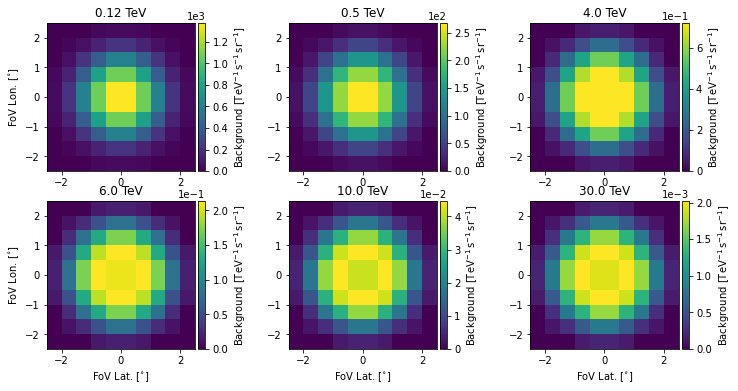

64081


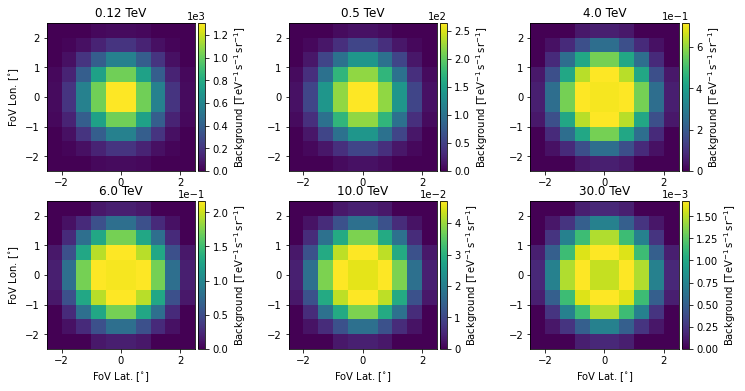

64082


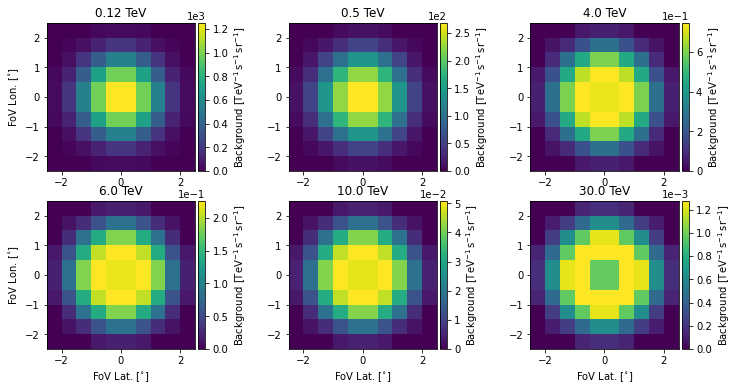

64083


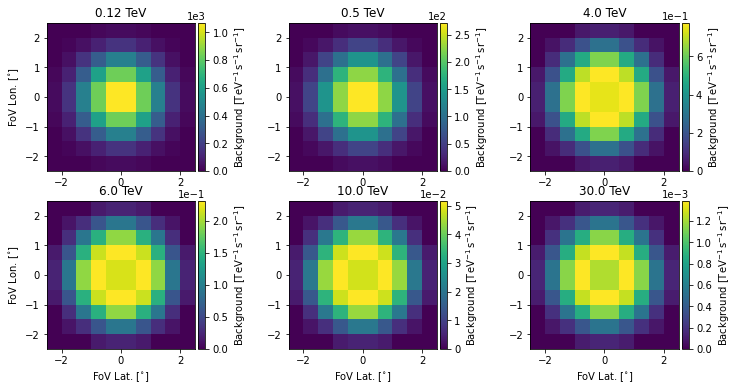

In [32]:
from gammapy.data import DataStore

my_data = DataStore.from_dir(config["io"]["out_dir"])
my_observations = my_data.get_observations()

for obs in my_observations:
    print(obs.obs_id)
    #obs.peek()
    obs.bkg.plot_at_energy([0.12 * u.TeV,0.5*u.TeV,4*u.TeV,6*u.TeV,10*u.TeV,30*u.TeV])
    plt.show()

# 3. Analysis

This performs a 1D (energy only) reflected regions analysis to get the spectrum and light curve (which gives an integrated flux value for all observations). Sky maps and significances are determined with a 2D (energy + acceptance) ring background analysis.

## i) Spectral analysis

Spectral analysis parameters are read in from the `spectrum` section of the config file

Performs a spectral analysis using reflected regions. The "ON" region is defined by `config['sky_map']['on_exclusion_region']` and should be $\sqrt{\theta^2}$ for point sources

If a spectrum type is not provided, this script will do a power law fit by default.

The **integral flux** is calculated by integrating a power law fit to the spectrum between `config["spectrum"]["e_min"]` and `config["spectrum"]["e_max"]`.

The first plot produced shows the exclusion regions used, and the second is an $E^2 \frac{dn}{de}$ spectrum.

In [9]:
spectral_points, spectral_model, cumulative_time, cumulative_sig, flux, flux_err = make_spectrum_RE(config, plot=False)

<Figure size 432x288 with 0 Axes>

$\frac{dn}{de}$ spectrum to match ED output (for validation purposes)

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

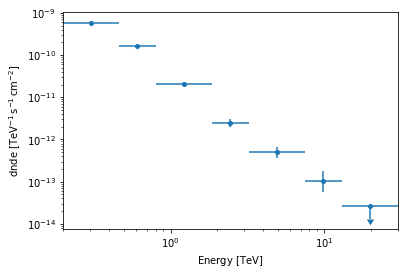

In [10]:
spectral_points.plot(sed_type='dnde')

## ii) Lightcurve maker - optional

Outputs the integral flux in units of $\textrm{cm}^2 \textrm{s}^{-1}$ (default) or a lightcurve

`get_flux_lc(config,"runwise")` will output a runwise lightcurve

`get_flux_lc(config,"custom")` will output a custom binned lightcurve. The binning is defined in `config['lightcurve']['bin_size_min']` as the time per bin in minutes. 

<Axes: xlabel='Time [iso]', ylabel='dnde [$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]'>

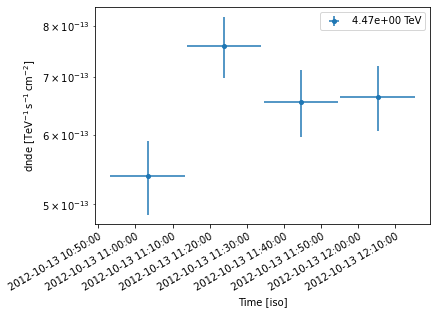

In [11]:
flux_points = get_flux_lc(config,"runwise")
flux_points.plot()
#lc_points = get_flux_lc(config,'runwise') # light curve maker

## iii) RBM analysis

Calculates counts, excess, significance, etc. using RBM normalized by the background files appended to each run.

Smaller skymap binning results in much longer runtimes. A binning of 0.01 deg is recommended to match ED, but fast analyses may be done with larger binning (gammapy default is 0.02 deg).

In [12]:
counts,background,alpha,sigma,excess_map,exposure,significance_map,exclusion_mask = rbm_analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4
Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Computing dataset for observation 64080
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 64081
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 64082
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 64083
Running MapDatasetMaker
Running SafeMaskMaker



## Plot results

Makes RBM maps (significance & excess) and RBM significance distribution. 1D cumulative significance from spectral analysis is also plotted.

These plots are saved with the prefix: `config['plot_names']`

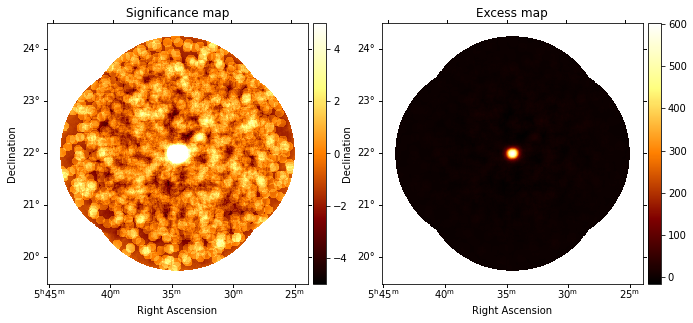

Fit results: mu = -0.04, std = 1.09


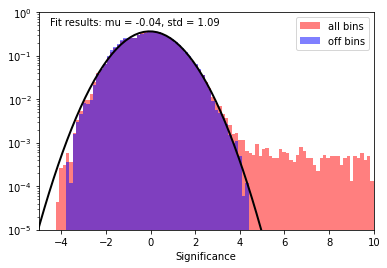

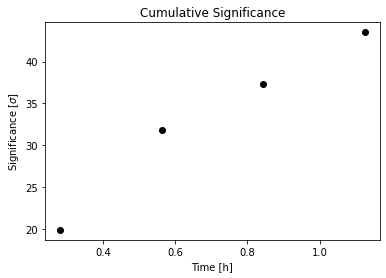

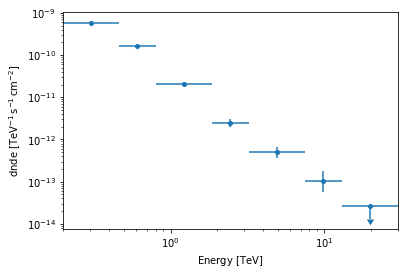

In [13]:
rbm_plots(config,spectral_points,excess_map, significance_map,cumulative_sig,cumulative_time,exclusion_mask)

# 4. Analysis output

Write the analysis output (currently formatted for inputting into the gammapy validation page: https://veritas.sao.arizona.edu/wiki/Gammapy_Validation).

This is saved in yaml format to `config['results_file']`.

**You should also upload your config file after validating a source for reproducibility!**

In [14]:
write_validation_info(config,spectral_model,flux,flux_err,counts,background,alpha,sigma,exposure)

======== RESULTS ========
analysis notebook version : 0.2
gammapy-tools version : 1.0.0
source : Crab
gammapy version : 1.2
exposure (min) : 80.13333333333328
on : 615
off : 17.86
alpha : 7.348e-02
significance : 48.06
flux : 2.83e-10 1 / (s cm2)
flux_err : 2.83e-10 1 / (s cm2)
flux_UL : n/a
norm : 3.46e-11
norm_err : 1.86e-12
index : 2.48
index_err : 0.06


# Write output in wiki format

In [15]:
spectab = spectral_model.to_parameters_table()
index = spectab["value"][0]
index_err = spectab["error"][0]
norm = spectab["value"][1]
norm_err = spectab["error"][1]
print(f'||notebook v1.0||{float(exposure.value) / 60}||{int(counts)}||{int(background)}||{alpha:.3e}||{sigma:.2f}||{flux:.2e} cm2 s-1||{flux_err:.2e} cm2 s-1||{norm:.2e} TeV-1 s-1 cm-2||{norm_err:.2e} TeV-1 s-1 cm-2||{index:.2f}||{index_err:.2f}||')

||notebook v1.0||80.13333333333328||615||17||7.348e-02||48.06||2.83e-10 1 / (s cm2) cm2 s-1||2.83e-10 1 / (s cm2) cm2 s-1||3.46e-11 TeV-1 s-1 cm-2||1.86e-12 TeV-1 s-1 cm-2||2.48||0.06||
